<a href="https://colab.research.google.com/github/muhakbarhamid21/digit-recognition/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

# Load Dataset

In [3]:
# Load training and testing datasets
train_df = pd.read_csv('emnist/emnist-digits-train.csv')
test_df = pd.read_csv('emnist/emnist-digits-test.csv')

# Reducing Data per Class

In [4]:
def reduce_data_by_class(df, n=1000):
    return df.groupby(df.columns[0]).apply(lambda x: x.sample(n=min(len(x), n), random_state=42)).reset_index(drop=True)

reduced_train_df = reduce_data_by_class(train_df, n=1000)
reduced_test_df = reduce_data_by_class(test_df, n=1000)

<ipython-input-4-8aae123e7f07>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(df.columns[0]).apply(lambda x: x.sample(n=min(len(x), n), random_state=42)).reset_index(drop=True)
<ipython-input-4-8aae123e7f07>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(df.columns[0]).apply(lambda x: x.sample(n=min(len(x), n), random_state=42)).reset_index(drop=True)


# Setting Up Features and Labels

In [5]:
y_train = reduced_train_df.iloc[:, 0].values
X_train = reduced_train_df.iloc[:, 1:].values

y_test = reduced_test_df.iloc[:, 0].values
X_test = reduced_test_df.iloc[:, 1:].values

# Preprocessing Data

In [6]:
# Reshape data: Assuming a 28x28 pixel image (grayscale)
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')

In [7]:
# Normalize pixel values ​​to the range [0, 1]
X_train /= 255.0
X_test /= 255.0

In [8]:
# One-hot encoding for labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Splitting Data into Training and Validation

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Data Exploration

In [10]:
unique, counts = np.unique(reduced_train_df.iloc[:, 0], return_counts=True)

print("Label distribution in training data:")

for label, count in zip(unique, counts):
    print(f"Label {label}: {count} data")

Label distribution in training data:
Label 0: 1000 data
Label 1: 1000 data
Label 2: 1000 data
Label 3: 1000 data
Label 4: 1000 data
Label 5: 1000 data
Label 6: 1000 data
Label 7: 1000 data
Label 8: 1000 data
Label 9: 1000 data


In [11]:
print("Training set shape\t\t:", X_train.shape)
print("Validation set shape\t\t:", X_val.shape)
print("Test set shape\t\t\t:", X_test.shape)

unique_labels_train = np.unique(np.argmax(y_train, axis=1))
unique_labels_test = np.unique(np.argmax(y_test, axis=1))

print("\nUnique labels in training set\t:", unique_labels_train)
print("Unique labels in test set\t:", unique_labels_test)

Training set shape		: (9000, 28, 28, 1)
Validation set shape		: (1000, 28, 28, 1)
Test set shape			: (10000, 28, 28, 1)

Unique labels in training set	: [0 1 2 3 4 5 6 7 8 9]
Unique labels in test set	: [0 1 2 3 4 5 6 7 8 9]


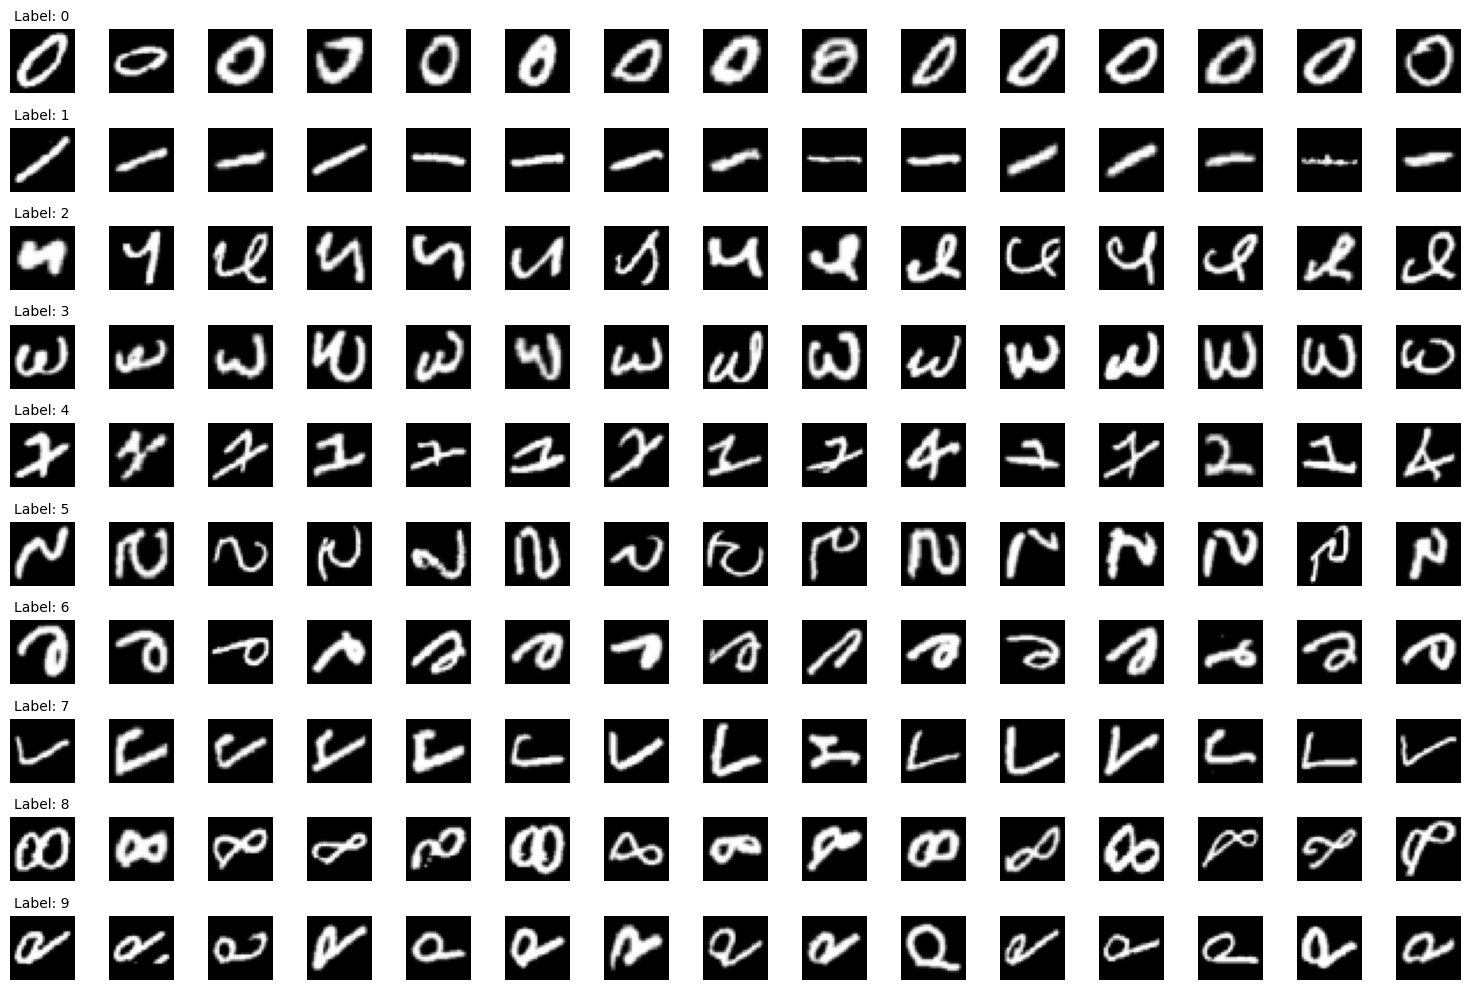

In [12]:
train_labels = np.argmax(y_train, axis=1)
unique_labels = np.unique(train_labels)

fig, axes = plt.subplots(nrows=len(unique_labels), ncols=15, figsize=(15, 1 * len(unique_labels)))

for i, label in enumerate(unique_labels):
    idxs = np.where(train_labels == label)[0][:15]
    for j, idx in enumerate(idxs):
        axes[i, j].imshow(X_train[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f"Label: {label}", fontsize=10)

plt.tight_layout()
plt.show()

# Modeling

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

# Training Model

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [17]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_val, y_val)
)


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.5564 - loss: 1.3670 - val_accuracy: 0.9390 - val_loss: 0.2338
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9217 - loss: 0.2622 - val_accuracy: 0.9690 - val_loss: 0.1330
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9465 - loss: 0.1900 - val_accuracy: 0.9720 - val_loss: 0.1036
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9611 - loss: 0.1271 - val_accuracy: 0.9760 - val_loss: 0.0927
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9684 - loss: 0.1116 - val_accuracy: 0.9740 - val_loss: 0.0973
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 0.0916 - val_accuracy: 0.9820 - val_loss: 0.0845
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9734 - loss: 0.0926 - val_accuracy: 0.9780 - val_loss: 0.0779
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9766 - loss: 0.0677 - val_accuracy: 0.9790 - val_loss

# Evaluation

In [21]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print("Training Accuracy (last epoch)\t\t:", final_train_acc)
print("Validation Accuracy (last epoch)\t:", final_val_acc)


Training Accuracy (last epoch)		: 0.99144446849823
Validation Accuracy (last epoch)	: 0.9829999804496765


In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest Accuracy\t\t\t\t:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9868 - loss: 0.0534

Test Accuracy				: 0.9846000075340271


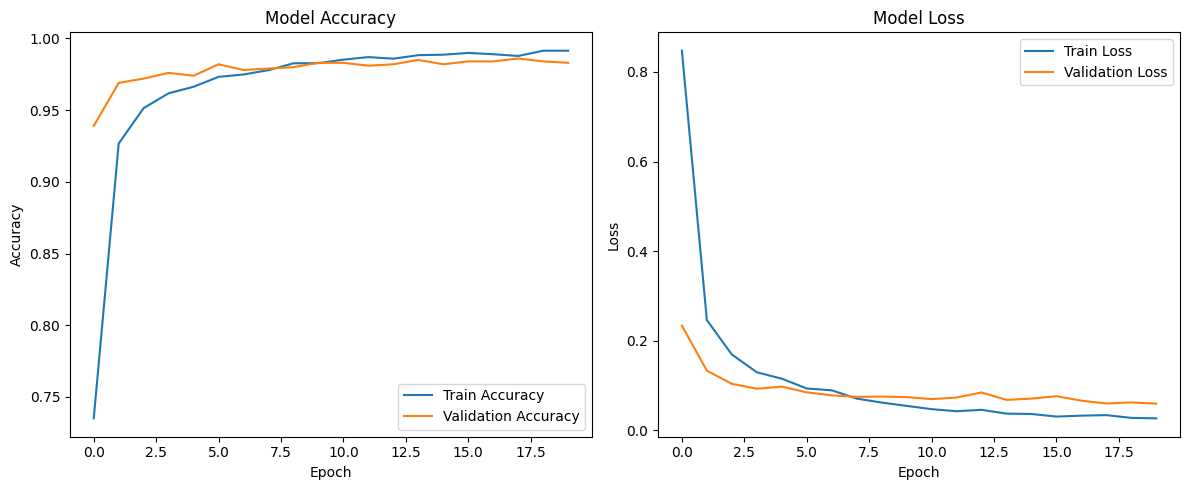

In [22]:
plt.figure(figsize=(12, 5))

# Plot acc
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save Model

## SavedModel

In [23]:
model.export('submission/saved_model')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138489496551248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475302800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475303376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475302032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475302224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475304336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489496551056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138489475304912: TensorSpec(shape=(), dtype=tf.resource, name=None)


## TF-Lite

In [24]:
import tensorflow as tf

# Konversi dari folder SavedModel ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Pastikan folder 'tflite' sudah ada; jika belum, buat folder tersebut
import os
if not os.path.exists('submission/tflite'):
    os.makedirs('submission/tflite')

# Simpan file TF-Lite
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# (Opsional) Simpan file label jika diperlukan
with open('submission/tflite/label.txt', 'w') as f:
    for i in range(num_classes):
        f.write(f"{i}\n")

## TFJS

In [27]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model submission/saved_model submission/tfjs_model

2025-03-24 06:44:00.141933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742798640.162257    6644 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742798640.168313    6644 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742798640.183863    6644 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742798640.183892    6644 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742798640.183896    6644 computation_placer.cc:177] computation placer alr

# Inference Model

In [44]:
sample_image = X_test[0].reshape(1, 28, 28, 1)

In [45]:
prediction = model.predict(sample_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [46]:
predicted_label = np.argmax(prediction)

Predicted Label: 0


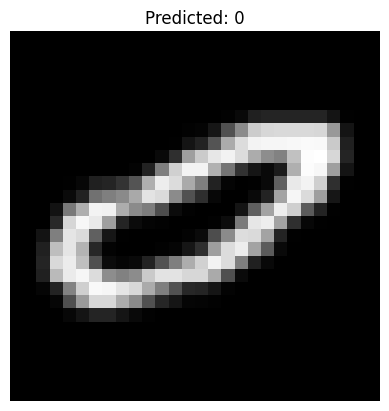

In [50]:
print("Predicted Label:", predicted_label)

plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

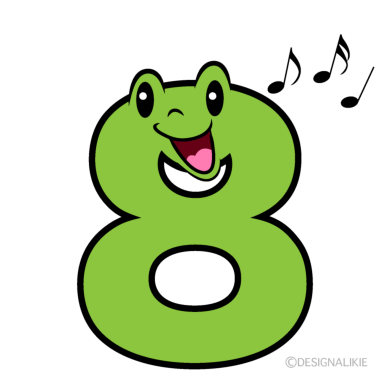

In [60]:
img = Image.open('8.png')

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

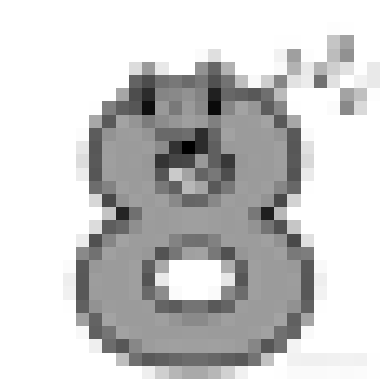

In [62]:
img = img.convert('L')

img = img.resize((28, 28))

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [63]:
img_arr = np.array(img).astype('float32') / 255.0

img_arr = img_arr.reshape(1, 28, 28, 1)

prediction = model.predict(img_arr)
predicted_label = np.argmax(prediction)
confidence = np.max(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [64]:
print("Model Output (Logits / Probabilities):", prediction)
print(f"Predicted Label: {predicted_label}, Confidence: {confidence:.4f}")

Model Output (Logits / Probabilities): [[1.8334629e-02 1.1278582e-05 2.0363526e-02 3.4901526e-04 3.1888296e-05
  2.0129704e-04 3.6682698e-03 4.6149121e-06 9.5641863e-01 6.1682396e-04]]
Predicted Label: 8, Confidence: 0.9564
